<a href="https://colab.research.google.com/github/AKShaffer/Group-2---Generative-AI-Tools-for-Drug-Repurposing-for-PD/blob/main/PD_VAE_BIOT670i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is adapted from: https://keras.io/examples/generative/molecule_generation/

# Novel SMILES generation using VAE and Parkinson's Disease market drugs as training data

**Author:** Angela Shaffer<br>
**Date created:** 2025/03/14<br>
**Last modified:** 2025/03/14<br>

## Introduction

This notebook implements a Variational Autoencoder (VAE) to generate SMILES strings for Parkinson's Disease (PD) drug discovery and potential drug repositioning if any of the novel molecules are similar to existing market approved drugs not currently approved for PD treatment.

This code is an adaptation of [**Drug Molecule Generation with VAE**](https://keras.io/examples/generative/molecule_generation/) by Victor Basu. The majority of the functions used in this notebook are from this Keras paper. Additional functions are derived from [WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/).

# Install packages and import dependencies

In [1]:
# Install and import dependencies
!pip -q install cairocffi
!pip -q install rdkit-pypi
!pip -q install Pillow
!pip -q install rdkit

'''
os: For interacting with the operating system.
io: For handling input and output operations.
sys: For system-specific parameters and functions.
google.colab, drive: Libraries specific to Google Colaboratory, used for mounting Google Drive to access files.
cv2: OpenCV (cv2), for computer vision tasks.
BytesIO: From the io module, for working with in-memory byte streams.
csv: For reading and writing CSV (Comma-Separated Values) files.
PIL, Image: Pillow (PIL) library for image manipulation.
os.environ["KERAS_BACKEND"] = "tensorflow": Sets the backend for Keras, a deep learning library, to TensorFlow.
ast: For working with Abstract Syntax Trees.
matplotlib, plt: Matplotlib for creating visualizations.
ipywidgets, widgets: For creating interactive widgets in Jupyter notebooks.
IPython, get_ipython, display: IPython functionalities for interactive computing and display in Jupyter notebooks.
pandas, pd: Pandas for data manipulation and analysis using DataFrames.
numpy, np: NumPy for numerical computing with arrays.
sklearn, TruncatedSVD: Scikit-learn for machine learning tasks, here importing TruncatedSVD for dimensionality reduction.
tensorflow, tf: TensorFlow for deep learning.
keras, layers, ops: Keras for building and training neural networks.
rdkit, Chem, RDLogger, etc.: RDKit, a cheminformatics library for working with chemical data, molecules, and their properties.
sys.path.append(...): Adds the RDKit's Contrib directory to the Python path, making its modules accessible.
sascorer: A module for calculating the Synthetic Accessibility Score (SAS) of molecules.
RDLogger.DisableLog("rdApp.*"): Disables specific RDKit logs to reduce output clutter.
'''

import os
import io
import sys
from google.colab import drive
drive.mount('/content/drive')
import cv2
from io import BytesIO
import csv

import PIL
from PIL import Image

os.environ["KERAS_BACKEND"] = "tensorflow"

import ast
import matplotlib
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython import get_ipython
from IPython.display import display

import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
import keras
from keras import layers
from keras import ops


import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, BondType, Crippen, Descriptors, Draw
from rdkit.Chem import MolToSmiles, QED, RDConfig, rdmolops, rdMolDescriptors
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, IPythonConsole, rdDepictor

# Add the RDKit's Contrib directory to the Python path
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

import sascorer

RDLogger.DisableLog("rdApp.*")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 715.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 16.3 MB/s eta 0:00:00
Mounted at /content/drive


# Dataset

The dataset is a curated list of market-approved drugs for treating Parkinson's Disease. The columns include the dataset include the molecule formula in SMILE representation along with their respective molecular properties such as **logP** (water–octanal partition coefficient), **SAS** (synthetic accessibility score) and **QED** (Qualitative Estimate of Drug-likeness).

NOTE: At the end of this notebook is a section titled **Supplemental Code** that contains additional helper functions that can be implemented as needed. These functions include functions for calculating logP, QED, and SAS scores in a smiles dataset.

Maximum number of atoms: 30


,smiles,logP,qed,sas
0,C1C2CC3CC1CC(C2)(C3)N,1.9139,0.562066,0.30
1,C1C2CC3CC1CC(C2)(C3)N.Cl,2.3357,0.619244,0.38
2,CN1CCC2=C3[C@H]1CC4=C(C3=CC=C2)C(=C(C=C4)O)O.Cl,3.2717,0.734189,0.61
3,CN1[C@@H]2CC[C@H]1CC(C2)OC(C3=CC=CC=C3)C4=CC=C...,3.9218,0.783948,1.21
4,CC(CC1=CC(=C(C=C1)O)O)(C(=O)O)NN.C1=CC(=C(C=C1...,-0.0009,0.163746,1.55


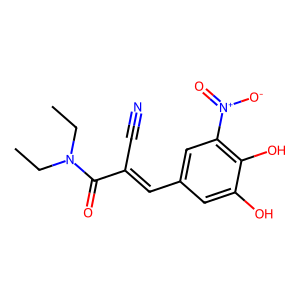

CCN(CC)C(=O)/C(=C/C1=CC(=C(C(=C1)O)O)[N+](=O)[O-])/C#N


In [6]:
# Download dataset
csv_path = '/content/drive/My Drive/VAE_GAN_Colab_Notebooks/Data/Full_Reference_Database_VAE_no repeats.csv'

df = pd.read_csv(csv_path)

# The function find_max_atoms iterates through each SMILES string in the 'smiles' column of the
# DataFrame. Each SMILES string is then converted into a molecule object (mol) using
# Chem.MolFromSmiles. The number of atoms in the molecule (num_atoms) is then obtained using
# mol.GetNumAtoms. The function then updates max_atoms to store the largest number of atoms
# encountered so far. Finally, it returns max_atoms, representing the maximum number of atoms in
# any molecule within the dataset.
def find_max_atoms(df):

    max_atoms = 0
    for smiles in df['smiles']:
        mol = Chem.MolFromSmiles(smiles)
        num_atoms = mol.GetNumAtoms()
        max_atoms = max(max_atoms, num_atoms)
    return max_atoms

# Find the highest number of atoms from a single SMILES data point
# from the dataset and display the result
result = find_max_atoms(df)
print("Maximum number of atoms:", result)

# Cleans the dataframe by removing newline characters from the smiles column
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))


# Displays the first few rows of the DataFrame, giving a glimpse of the data.
display(df.head())
# Takes the SMILES string from the 6th row (index 5) of the DataFrame and converts it into a
# molecule object, then displays an image and the smiles of the molecule object.
molecule = Chem.MolFromSmiles(df["smiles"][5])
display(Draw.MolToImage(molecule))
print(df["smiles"][5])

## Defining Hyperparameters

In [7]:
# Function to extract unique atom types from SMILES
def get_unique_atoms(smiles_list):
    unique_atoms = set()
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            for atom in mol.GetAtoms():
                unique_atoms.add(atom.GetSymbol())
    return unique_atoms

# Map each unique atom type to a dictionary
def map_atoms_to_dict(unique_atoms):
    atom_dict = {}
    for idx, atom in enumerate(sorted(unique_atoms)):
        atom_dict[atom] = idx
    return atom_dict

SMILE_CHARSET = get_unique_atoms(df["smiles"])

# bond_mapping: This dictionary maps bond types (e.g., 'SINGLE', 'DOUBLE') to numerical indices
# and vice-versa. This is similar to the atom mapping and is used for representing bonds in the
# model.
bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)

'''
MAX_MOLSIZE, MIN_MOLSIZE: These variables store the maximum and minimum lengths of the SMILES
strings in the dataset, respectively. This gives an idea of the size range of the molecules.
SMILE_to_index, index_to_SMILE: These dictionaries provide mappings between the unique
characters in the SMILES strings and numerical indices, similar to what we had for atoms and
bonds.
atom_mapping: A combination of the SMILE_to_index and index_to_SMILE mappings, for convenient
access to atom-to-index and index-to-atom conversions.
BATCH_SIZE: This hyperparameter determines how many samples are processed together during
training.
VAE_LR: Learning rate for the VAE optimizer, a parameter that controls the step size during
model optimization.
NUM_ATOMS: Stores the maximum number of atoms in any molecule in the dataset (result), which
helps define the input size for the model.
ATOM_DIM: Number of unique atom types in the dataset, defining the size of the feature vectors
representing atoms.
BOND_DIM: Number of bond types (including "non-bond"), which is used to represent the
connectivity between atoms.
LATENT_DIM: The size of the latent space in the VAE, representing the compressed representation
 of the molecules.
'''
MAX_MOLSIZE = max(df["smiles"].str.len())
MIN_MOLSIZE = min(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
print(atom_mapping)

BATCH_SIZE = 100

VAE_LR = 5e-4
NUM_ATOMS = result  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space


# smiles_to_graph: This function takes a SMILES string as input and converts it into a graph
# representation consisting of two tensors:
  # adjacency: A tensor representing the bonds between atoms in the molecule.
  # features: A tensor representing the features of each atom in the molecule (e.g., atom type).
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

# graph_to_molecule: This function takes the graph representation (adjacency and features) and
# converts it back into a molecule object
def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles of the [symmetric]
    # adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for bond_ij, atom_i, atom_j in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; This function removes invalid smiles. For more information on
    # sanitization, see https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Strict sanitization rules implemented i.e., if sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

{'S': 0, 'C': 1, 'F': 2, 'O': 3, 'Cl': 4, 'N': 5, 0: 'S', 1: 'C', 2: 'F', 3: 'O', 4: 'Cl', 5: 'N'}


## Prepare and transform training dataset

In [8]:
# train_df = df.sample(frac=1, random_state=42): This line shuffles the rows of the DataFrame df
# to randomize the data for training. frac=1 means it shuffles all rows. random_state=42 ensures
# that the shuffling is reproducible, meaning you'll get the same order every time you run the
# code with this seed.
train_df = df.sample(frac=1, random_state=42)  # random state is a seed value

# train_df.reset_index(drop=True, inplace=True): After shuffling, the index of the DataFrame is
# reset to sequential numbers (0, 1, 2, etc.), and the old index is dropped using drop=True.
# inplace=True modifies the DataFrame directly.
train_df.reset_index(drop=True, inplace=True)

# row_count = len(train_df): This gets the total number of rows (data points) in the shuffled
# DataFrame.
row_count = len(train_df)  # Use this for training sets less than 8000

# adjacency_tensor, feature_tensor, qed_tensor = [], [], []: This initializes three empty lists
# to store the adjacency matrices, feature matrices, and QED values for each molecule,
# respectively.
adjacency_tensor, feature_tensor, qed_tensor = [], [], []

# for idx in range(row_count):: This loop iterates through each row of the train_df DataFrame.
for idx in range(row_count): # Use this for training sets less than 8000
# for idx in range(8000):   # Use this for the original code

    # adjacency, features = smiles_to_graph(train_df.loc[idx]["smiles"]): Inside the loop, this
    # line calls the smiles_to_graph function (defined earlier in the code). This function takes
    # a SMILES string (representing a molecule) and converts it into its graph representation
     # (adjacency and feature matrices).
    adjacency, features = smiles_to_graph(train_df.loc[idx]["smiles"])

    # qed = train_df.loc[idx]["qed"]: This line extracts the QED value for the current molecule
    # from the train_df DataFrame.
    qed = train_df.loc[idx]["qed"]

    # adjacency_tensor.append(adjacency), feature_tensor.append(features), qed_tensor.append(qed):
    # These lines add the adjacency matrix, feature matrix, and QED value of the current molecule
    # to their respective lists.
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
    qed_tensor.append(qed)

# adjacency_tensor = np.array(adjacency_tensor), feature_tensor = np.array(feature_tensor),
# qed_tensor = np.array(qed_tensor): These lines convert the lists into NumPy arrays, a format
# suitable for using with Keras/TensorFlow.
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
qed_tensor = np.array(qed_tensor)

# This class defines a custom Keras layer. This is essential for processing the graph
# representations of the molecules.
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    # build: This method is called when the layer is first used and creates the layer's weights
    # (kernel and optional bias).
    # input_shape: This argument provides information about the shape of the data that will be
    # fed into the layer. It's a tuple representing the dimensions of the input tensors
     # (think of them as multi-dimensional arrays).
    def build(self, input_shape):
        # bond_dim: This variable is assigned the value of the bond dimension, which is
        # extracted from the input_shape. It represents the number of different bond types in
        # the molecules being considered (e.g., single, double, aromatic bonds).
        bond_dim = input_shape[0][1]
        #  atom_dim: Similar to bond_dim, this gets the atom dimension from the input_shape,
        # representing the different atom types (e.g., carbon, oxygen, nitrogen).
        atom_dim = input_shape[1][2]

        # self.kernel: This is where the layer's main weights (also called the kernel) are stored.
        # These weights are the learnable parameters of the layer, which will be adjusted during
        # the training process to improve the model's performance.
        # self.add_weight: This is a Keras function that creates a new weight variable and adds
        # it to the layer's trainable parameters.

        self.kernel = self.add_weight(

            # shape: This argument defines the dimensions of the kernel. In this case, it's a 3D
            # tensor with dimensions (bond_dim, atom_dim, self.units). The self.units value was
            # specified when the layer was created and determines the number of output features
            # for this layer.
            shape=(bond_dim, atom_dim, self.units),

            # initializer: This determines how the initial values of the weights are set. It's
            # usually a function from the keras.initializers module. A good initialization
            # strategy helps the model learn effectively.
            initializer=self.kernel_initializer,

            # regularizer: This optional argument adds a penalty to the loss function to prevent
            # overfitting. This encourages the model to learn more general patterns and avoid
            # memorizing the training data too closely.
            regularizer=self.kernel_regularizer,

            # trainable=True: This means that the kernel weights will be updated during training.
            trainable=True,

            # name="W": This gives the weight variable a name, which can be helpful for debugging
            # and understanding the model's structure.
            name="W",

            # dtype="float32": Specifies the data type of the weights, commonly 32-bit
            # floating-point numbers.
            dtype="float32",
        )

        # This block is similar to the kernel creation but is only executed if self.use_bias is
        # True. A bias is an additional learnable parameter that can be added to the layer's
        # output, providing more flexibility during training.
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype="float32",
            )
        # This set the built flag indicating that the layer has been built and its weights have
        # been initialized. This prevents the build method from being called multiple times.
        self.built = True

    # call: This method defines the layer's forward pass, taking the adjacency and feature
    # matrices as input and performing the graph convolution operation. It involves matrix
    # multiplications, applying the activation function, and potentially adding a bias.
    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = ops.matmul(adjacency, features[:, None])
        # Apply linear transformation
        x = ops.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = ops.sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

## Build the Encoder and Decoder

The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.

**Graph Convolution layer**: The relational graph convolution layer implements
non-linearly transformed neighbourhood aggregations. We can define these layers as
follows:

`H_hat**(l+1) = σ(D_hat**(-1) * A_hat * H_hat**(l+1) * W**(l))`

Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H_hat**(l)` the feature tensor at the `l-th` layer, `D_hat**(-1)` the
inverse diagonal degree tensor of `A_hat`, and `W_hat**(l)` the trainable weight tensor
at the `l-th` layer. Specifically, for each bond type (relation), the degree tensor
expresses, in the diagonal, the number of bonds attached to each atom.

Source:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/))

The Decoder takes as input the latent-space representation and predicts
the graph adjacency matrix and feature matrix of the corresponding molecules.

In [9]:
# This function builds the encoder part of the VAE. The encoder's job is to take a molecule
# represented as a graph (defined by adjacency and features) and compress it into a
# lower-dimensional representation called the latent space.
def get_encoder(
    gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate
):
    adjacency = layers.Input(shape=adjacency_shape)  # The adjacency matrix describes atom connections
    features = layers.Input(shape=feature_shape)  # The feature matrix describes atom properties

    # Propagate through one or more graph convolutional layers. These layers are designed to
    # learn patterns in the graph structure of the molecule. Information from neighboring
    # atoms is then aggregated to create a more informative representation of each atom.
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D. This essentially averages the feature
    # values across all atoms in the molecue.
    x = layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers. The output from pooling is passed
    # through one or more dense (fully connected) layers with ReLU activation. These layers
    # further process the information and learn complex relationships. layers.Dropout() is
    # applied to prevent overfitting. This randomly sets a fraction of input units to 0 at each
    #  update during training time, which helps prevent the model from relying too much on any
    # single feature.
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Two dense layers are used to output z_mean and log_var. These represent the mean and
    # logarithm of the variance of the molecule's distribution in the latent space. The latent
    # space is a lower-dimensional representation of the molecule, capturing its essential
    # features.
    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    # The encoder model takes the adjacency and features as input and outputs z_mean and log_var.
    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

# This function builds the decoder part of the VAE. The decoder's task is to take a point from
# the latent space (the compressed representation of a molecule) and reconstruct the original
# molecule's graph representation.
def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):

    # Takes a point in the latent space (latent_inputs) as input.
    latent_inputs = keras.Input(shape=(latent_dim,))

    # The latent space representation is passed through one or more dense layers with tanh
    # activation and dropout for regularization.
    x = latent_inputs
    for units in dense_units:
        x = layers.Dense(units, activation="tanh")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Reconstruction: Two separate branches are created to reconstruct:
      # Adjacency Matrix: Dense layer followed by reshape and softmax to predict the
      # adjacency matrix. The adjacency matrix is symmetrized to ensure the connections
      # between atoms are consistent.
      # Feature Matrix: Dense layer followed by reshape and softmax to predict the feature matrix.

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = layers.Dense(np.prod(adjacency_shape))(x)
    x_adjacency = layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + ops.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = layers.Dense(np.prod(feature_shape))(x)
    x_features = layers.Reshape(feature_shape)(x_features)
    x_features = layers.Softmax(axis=2)(x_features)

    # The decoder model takes latent_inputs as input and outputs the reconstructed
    # x_adjacency and x_features.
    decoder = keras.Model(
        latent_inputs, outputs=[x_adjacency, x_features], name="decoder"
    )

    return decoder

## Building the Sampling Layer
This class defines a custom Keras layer called Sampling. This class's job is to sample points from the latent space. In simpler terms, the Sampling layer takes the encoder's output and adds some random noise to it, creating a point in the latent space. This point is then fed to the decoder to generate a new molecule. The randomness introduced by this layer is what allows the VAE to create diverse and novel molecules.

### What is the Latent Space?
In a VAE, the latent space is a lower-dimensional representation of the input data (in this case, molecules). Think of it as a compressed version of the molecules, where similar molecules are clustered together. The Sampling layer helps the VAE generate new molecules by randomly picking points within this latent space.

In [10]:
class Sampling(layers.Layer):
    # __init__(self, seed=None, **kwargs):
    # This is the constructor of the class. It initializes the layer.

    # seed:
    # An optional argument to set a seed for the random number generator, making the sampling
    # process reproducible.

    # **kwargs:
    # Allows you to pass additional keyword arguments to the parent class (layers.Layer).
    def __init__(self, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(seed)

    # call(self, inputs):
    # This is the core of the layer's functionality. It's executed when the layer is called
    # during the model's forward pass.
    def call(self, inputs):
        # inputs: A tuple containing z_mean and z_log_var. These are the outputs of the encoder,
        # representing the mean and logarithm of the variance of the latent distribution.
        z_mean, z_log_var = inputs
        # batch, dim = ops.shape(z_log_var): Gets the batch size (batch) and dimensionality
        # (dim) of the latent space from z_log_var.
        batch, dim = ops.shape(z_log_var)
        # epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator): This line
        # is where the actual sampling happens. It draws random samples (noise) from a normal
        # distribution with the shape of the latent space. The seed ensures reproducibility if
        # provided.
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        # return z_mean + ops.exp(0.5 * z_log_var) * epsilon: This is the "reparameterization
        # trick." It combines the mean (z_mean), the standard deviation
        # (calculated from z_log_var), and the random noise (epsilon) to get a sample from the
        #  latent space. This trick is important for making the VAE trainable using backpropagation.
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

## Build the VAE

This model is trained to optimize four losses:

* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)

The categorical crossentropy loss function measures the model's reconstruction accuracy. The Property prediction loss estimates the mean squared error between predicted and actual properties after running the latent representation through a property prediction model. The property prediction of the model is optimized via binary crossentropy. The gradient penalty is further guided by the model's property (QED) prediction.

A gradient penalty is an alternative soft constraint on the 1-Lipschitz continuity as an improvement upon the gradient clipping scheme from the original neural network ("1-Lipschitz continuity" means that the norm of the gradient is at most 1 at every single point of the function). It adds a regularization term to the loss function.

In [28]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder # Takes a molecule and compresses it into a code (latent space representation)
        self.decoder = decoder # Takes the code reconstructs the molecule
        self.property_prediction_layer = layers.Dense(1) # Predicts molecular properties from the code
        self.max_len = max_len # Maximum length of the molecules's represenation
        self.seed_generator = keras.random.SeedGenerator(seed) # For reproducible results
        self.sampling_layer = Sampling(seed=seed) # Adds randomness for generating diverse molecules

        # train_total_loss_tracker and val_total_loss_tracker track the model's performance during training.
        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    # This function defines how the model learns from data. It's like training the factory
    # workers to improve their skills. It takes a batch of data (data), which includes molecule
    # representations and properties. It calculates the loss, which measures how well the model
    # is doing. It updates the model's parameters to minimize the loss, making it better at
    # generating molecules.
    def train_step(self, data):
        # Unpack the input data to get the adjacency_tensor, feature_tensor, and qed_tensor
        # adjacency_tensor and feature_tensor represent the actual molecule's graph structure
        # and are combined into graph_real. qed_tensor holds the target property values
        # (Quantitative Estimate of Drug-likeness) for the molecules in the batch.
        adjacency_tensor, feature_tensor, qed_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = ops.shape(qed_tensor)[0]  # This is set based on the size of qed_tensor

        # tf.GradientTape() is used to record operations for automatic differentiation,
        # which is necessary for calculating gradients during backpropagation.
        with tf.GradientTape() as tape:
            # The model (self) is called with graph_real to get the:
                # z_mean and z_log_var: Latent space representation of the input molecule.
                # qed_pred: Predicted QED value.
                # gen_adjacency and gen_features: Reconstructed graph representation.
                # graph_generated combines the reconstructed adjacency and feature tensors.
                # self._compute_loss is called to calculate the total loss
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(
                graph_real, training=True
            )
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(
                z_log_var, z_mean, qed_tensor, qed_pred, graph_real, graph_generated
            )
        # tape.gradient calculates the gradients of the total_loss with respect to the model's
        # trainable weights.
        grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients updates the model's weights based on the calculated
        # gradients, aiming to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # The train_total_loss_tracker is updated with the current total_loss.
        # The function returns a dictionary containing the current average training loss.
        self.train_total_loss_tracker.update_state(total_loss)
        return {"loss": self.train_total_loss_tracker.result()}

    # _compute_loss is a helper function that calculates the total loss based on:
        # kl_loss: Measures how well the latent space captures information.
        # property_loss: Measures how accurately the model predicts molecular properties.
        # graph_loss: Measures the quality of the generated molecule graphs.
        # adjacency_loss, features_loss: Measure the accuracy of the reconstructed molecule parts.
    def _compute_loss(
        # self: Refers to the MoleculeGenerator instance itself.
        # z_log_var: Logarithm of the variance of the latent space representation.
        # z_mean: Mean of the latent space representation.
        # qed_true: The true Quantitative Estimate of Drug-likeness (QED) values for the input
        # molecules.
        # qed_pred: The predicted QED values by the model.
        # graph_real: The actual graph representation of the input molecules, containing
        # adjacency_real (connectivity) and features_real (atom properties).
        # graph_generated: The graph representation generated by the decoder, containing
        # adjacency_gen and features_gen.
        self, z_log_var, z_mean, qed_true, qed_pred, graph_real, graph_generated
    ):
        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        # adjacency_loss: Measures how well the generated adjacency matrix matches the real
        # adjacency matrix using categorical cross-entropy. This essentially quantifies the
        # difference in connectivity between the generated and real molecules.
        adjacency_loss = ops.mean(
            ops.sum(
                keras.losses.categorical_crossentropy(
                    adjacency_real, adjacency_gen, axis=1
                ),
                axis=(1, 2),
            )
        )
        # Similar to `adjacency_loss`, but it measures the difference between the generated and
        # real feature matrices (atom properties) using categorical cross-entropy.
        features_loss = ops.mean(
            ops.sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis=(1),
            )
        )
        # kl_loss stands for Kullback-Leibler divergence loss. It encourages the latent space
        # distribution to be close to a standard normal distribution, which helps in generating
        # diverse and meaningful molecules.
        kl_loss = -0.5 * ops.sum(
            1 + z_log_var - z_mean**2 - ops.minimum(ops.exp(z_log_var), 1e6), 1
        )
        kl_loss = ops.mean(kl_loss)

        # property_loss measures how well the model predicts the QED property of the molecules
        # using binary cross-entropy. This ensures the generated molecules have desired properties.
        property_loss = ops.mean(
            keras.losses.binary_crossentropy(qed_true, ops.squeeze(qed_pred, axis=1))
        )

        # graph_loss is calculated using a separate function, `_gradient_penalty`. It acts as a
        # regularization term to ensure the generated molecules are realistic and avoid
        # unnatural structures.
        graph_loss = self._gradient_penalty(graph_real, graph_generated)

        # This returns the total loss, which is the sum of all the individual loss components.
        # This total loss is what the model tries to minimize during training.
        return kl_loss + property_loss + graph_loss + adjacency_loss + features_loss

    # The _gradient_penalty function adds a penalty to the loss to ensure the latent space is
    # smooth and continuous. This helps in generating more realistic molecules.
    def _gradient_penalty(self, graph_real, graph_generated):

        # Unpack graphs
        adjacency_real, features_real = graph_real # Represents connectivity of atoms in the molecules
        adjacency_generated, features_generated = graph_generated # Represents the properties of the atoms in the molecules

        # Generate interpolated graphs (adjacency_interp and features_interp)
        # alpha: A random number between 0 and 1 is generated for each molecule in the batch.
        # This alpha is used to create interpolated graphs.
        alpha = keras.random.uniform(shape=(self.batch_size,), seed=self.seed_generator)
        alpha = ops.reshape(alpha, (self.batch_size, 1, 1, 1))

        # adjacency_interp, features_interp: These are created by linearly interpolating between
        # the real and generated graphs using alpha. This essentially creates a mix of the real
        # and generated molecules.
        adjacency_interp = (adjacency_real * alpha) + (
            1.0 - alpha
        ) * adjacency_generated
        alpha = ops.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1.0 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        # tf.GradientTape() is used to record operations so that gradients can be calculated later.
        # tape.watch() tells the tape to watch the interpolated graphs for changes.
        # self(...): The model is called with the interpolated graphs to get the logits
         # (which are intermediate outputs of the model).
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _, _ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        # tape.gradient() calculates the gradients of the logits with respect to the interpolated graphs.
        grads = tape.gradient(logits, [adjacency_interp, features_interp])

        # Compute the gradient penalty
        # grads_adjacency_penalty, grads_features_penalty: These calculate the penalty based on
        # how far the gradients deviate from 1 (which is related to the 1-Lipschitz constraint).
        grads_adjacency_penalty = (1 - ops.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - ops.norm(grads[1], axis=2)) ** 2

        # The final return value is the mean of these penalties.
        return ops.mean(
            ops.mean(grads_adjacency_penalty, axis=(-2, -1))
            + ops.mean(grads_features_penalty, axis=(-1))
        )
    # This is the part where the 'factory' produces new molecules. Random points in the latent
    # space are sampled and the decoder is then used  to generate corresponding molecule graphs.
    # The graphs are then converted into RDKit molecule objects, which represent the generated
    # molecules.  It takes a batch_size as input, which determines how many new molecules to
    # generate at once.
    def inference(self, batch_size):
        # keras.random.normal: This line generates random points (z) in the latent space. These
        # points will be the starting point for creating new molecules.
        z = keras.random.normal(

            # shape=(batch_size, LATENT_DIM): This specifies the shape of the random points.
            # It creates a matrix with batch_size rows (one for each molecule) and LATENT_DIM
            # columns (representing the dimensions of the latent space).
            # seed=self.seed_generator: This ensures that the random number generation is
            # reproducible, meaning you'll get the same results if you run the code again with
            # the same seed.
            shape=(batch_size, LATENT_DIM), seed=self.seed_generator
        )
        # model.decoder.predict(z): This line feeds the random points (z) from the latent space
        # into the decoder part of the VAE. The decoder's job is to translate these points
        # back into a representation of a molecule.
        # reconstruction_adjacency, reconstruction_features: The decoder outputs two things: the
        # reconstruction_adjacency (which describes how atoms are connected in the molecule) and
        # reconstruction_features (which describes the properties of each atom).
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)

        # ops.argmax(...) and ops.one_hot(...): These lines convert the reconstruction_adjacency
        # into a one-hot encoded adjacency tensor. This format is easier for the model to work with.
        adjacency = ops.argmax(reconstruction_adjacency, axis=1)
        adjacency = ops.one_hot(adjacency, num_classes=BOND_DIM, axis=1)

        # adjacency = adjacency * ...: This line removes any potential self-loops in the
        # adjacency matrix. Self-loops represent an atom being connected to itself, which is
        # chemically invalid.
        adjacency = adjacency * (1.0 - ops.eye(NUM_ATOMS, dtype="float32")[None, None])

        # Similar to the adjacency matrix processing, these lines convert the reconstruction_features
        # into a one-hot encoded tensor, making it easier to handle.
        features = ops.argmax(reconstruction_features, axis=2)
        features = ops.one_hot(features, num_classes=ATOM_DIM, axis=2)

        # graph_to_molecule(...): This line takes the processed adjacency and feature matrices
        # and converts them back into RDKit molecule objects. RDKit is a library for working with
        # chemical data. The code iterates through the batch and creates a list of RDKit molecule
        # objects, one for each generated molecule.
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]

    # call() defines how the model processes input and produces output. It's automatically
    # executed when you use the model to make predictions or during training.
    def call(self, inputs):
        # z_mean, log_var = self.encoder(inputs): This line takes the inputs (which represent a
        # molecule's graph) and feeds them into the encoder. The encoder processes the graph and
        # outputs two important things: z_mean and log_var. These represent the molecule's
        # compressed representation in the latent space (a lower-dimensional space where similar
        # molecules are clustered together).
        z_mean, log_var = self.encoder(inputs)

        # adjacency_tensor, feature_tensor = inputs  # Unpack inputs
        # z_mean, log_var = self.encoder([adjacency_tensor, feature_tensor])  # Pass to encoder

        # z = self.sampling_layer([z_mean, log_var]): This line uses the sampling_layer to introduce
        # some randomness. It takes z_mean and log_var and adds random noise to them, creating a
        # point (z) in the latent space. This randomness is crucial for generating diverse and
        # novel molecules.
        z = self.sampling_layer([z_mean, log_var])

        # gen_adjacency, gen_features = self.decoder(z): The sampled point z is then passed to
        # the decoder. The decoder's job is to reconstruct the molecule's graph from this latent
        # space representation. It outputs gen_adjacency and gen_features, which represent the
        # connections between atoms and the properties of each atom in the generated molecule.
        gen_adjacency, gen_features = self.decoder(z)

        # property_pred = self.property_prediction_layer(z_mean): This line uses the
        # property_prediction_layer to estimate the properties of the generated molecule based
        # on its latent space representation (z_mean).
        property_pred = self.property_prediction_layer(z_mean)

        # return z_mean, log_var, property_pred, gen_adjacency, gen_features: The function returns
        # all the important information: the latent space representation (z_mean, log_var), the
        # predicted property (property_pred), and the generated molecule's graph
        # (gen_adjacency, gen_features).
        return z_mean, log_var, property_pred, gen_adjacency, gen_features

## Train the model
This code block focuses on training the Variational Autoencoder (VAE) model to generate new molecules. It involves setting up the optimizer, creating the encoder and decoder components, building the overall model, and finally training it.

In [46]:
# vae_optimizer: This variable stores the optimization algorithm used to train the VAE model.
    # keras.optimizers.Adam: This is a popular optimization algorithm in deep learning.
    # learning_rate=VAE_LR: This sets the learning rate, a hyperparameter that controls how much
    # the model's parameters are adjusted during each training step. VAE_LR is a variable defined
    # in the 'Defining Hyperparameters' code block section of this code.
vae_optimizer = keras.optimizers.Adam(learning_rate=VAE_LR)

# encoder: This variable stores the encoder part of the VAE.
# get_encoder: This function (defined earlier) builds the encoder network.
# The parameters (gconv_units, adjacency_shape, feature_shape, latent_dim, dense_units,
# dropout_rate) define the architecture of the encoder network, such as the number of layers,
# their sizes, and other properties.
encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)

# decoder: This variable stores the decoder part of the VAE.
# get_decoder: Similar to get_encoder, this function (defined earlier) builds the decoder network.
# The parameters (dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape) define
# the architecture of the decoder.
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

# model: This variable stores the complete VAE model.
    # MoleculeGenerator: This is the class (defined earlier) that combines the encoder, decoder,
    # and other components to form the VAE.
    # encoder, decoder, MIN_MOLSIZE: These are passed as arguments to create the VAE model.
model = MoleculeGenerator(encoder, decoder, MIN_MOLSIZE)

# model.compile: This prepares the model for training by specifying the optimizer.
    # vae_optimizer: The previously defined Adam optimizer.
model.compile(vae_optimizer)

# model.fit: This starts the training process.
    # [adjacency_tensor, feature_tensor, qed_tensor]: This is the training data.
    # adjacency_tensor: Represents the connectivity of atoms in the molecules.
    # feature_tensor: Represents properties of the atoms in the molecules.
    # qed_tensor: Represents the Quantitative Estimate of Drug-likeness, a property of the molecules
    # used for training.
    # epochs=500: This sets the number of training epochs. One epoch means the model has seen the
    # entire training dataset once.
history = model.fit([adjacency_tensor, feature_tensor, qed_tensor], epochs=600)

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1526.4982
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 1491.7333
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1453.6318
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 1377.8082
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1305.8412
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1201.7336
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1067.0481
Epoch 8/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 872.5327
Epoch 9/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 727.9157
Epoch 10/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 544.6755
Epoch 11/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 440.3062
Epoch 12/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 330.7890
Epoch 13/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 255.2581
Epoch 14/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 217.1199
Epoch 15/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms

## Inference
We use our model to generate new valid molecules from different sampled points of the latent space. We then use RDKit to calculate the qed of the generated smiles. Invalid smiles and any smiles that score below the mean QED threshold for approved drugs (0.492) are rejected and printed to the screen. Generated smiles that score >=0.492 QED are retained and their logP, sas, and molecular weight are calculated using additional RDKit functions. The retained smiles are then displayed in an image. Button and textboxt widgets are displayed that provide the user the option to save the image file and the csv.

The user may re-run this code block multiple times to sample and display molecules generated by the VAE. Clicking the Save_CSV after re-run of this code block will then check if there is an existing generated_molecules.csv file (or whatever file name as specified by the user). If there is an existing file, the script will check if the newly generated smiles are duplicates before saving to the CSV. Only new smiles molecules will be saved to the csv. This procedure can be used to append multiple smiles generated by each run of this code block to a csv without adding duplicates.


**Reference for QED mean threshold:**
Bickerton, G. R., Paolini, G. V., Besnard, J., Muresan, S., & Hopkins, A. L. (2012). Quantifying the chemical beauty of drugs. *Nature chemistry, 4*(2), 90-98. (https://doi.org/10.1038/nchem.1243)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Invalid SMILES encountered: CCCCC1CCCCC1
Molecules with low QED score encountered: CC1CC2CCCC(C1)C2. Score: 0.4818675899459252
Molecules with low QED score encountered: C1=C2CC3CC1CC(C2)C3. Score: 0.44677422675976775
Invalid SMILES encountered: CCCC1CCCCC1
Molecules with low QED score encountered: C1=C2CC3CC1CC(C2)C3. Score: 0.44677422675976775
Molecules with low QED score encountered: CCCCCCCCC. Score: 0.4777243799437154
Molecules with low QED score encountered: CC1CC2CCCC(C1)C2. Score: 0.4818675899459252
Molecules with low QED score encountered: CC1CCC2CCCC1C2. Score: 0.4818675899459252
Molecules with low QED score encountered: CCCCCCCCC. Score: 0.4777243799437154
Molecules with low QED score encountered: C1C2CC3CC1CC(C2)C3. Score: 0.48010090237684666
Molecules with low QED score encountered: CC1CC2CCCC(C1)C2. Score: 0.4818675899459252
Molecules with low QED score encountered: C1=C2CC3CC1CC1C2C31. Score: 0.4432279153146454
Molecules with low QE

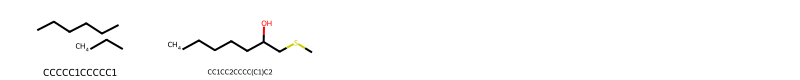

Text(value='my_molecules.png', description='Filename:')

Button(description='Save Image', style=ButtonStyle())

Text(value='generated_molecules.csv', description='CSV Filename:')

Button(description='Save CSV', style=ButtonStyle())

SMILES and properties saved to generated_molecules.csv


In [69]:
def calculate_and_save_properties_from_smiles(smiles_list, filename="generated_molecules.csv", print_messages=True):
    """
    Calculates properties for a list of SMILES strings and saves SMILES and QED to a CSV file.

    Args:
        smiles_list: A list of SMILES strings.
        filename: The name of the CSV file to save the data to.
    """
    data_to_save = []
    valid_molecules = []
    existing_smiles = set() # To store existing SMILES from the csv

    # Load existing SMILES from the CSV file if it exists
    try:
        with open(filename, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header row
            for row in reader:
                existing_smiles.add(row[0])  # Add SMILES from the first column
    except FileNotFoundError:
        pass  # If file doesn't exist, continue

    for smiles in smiles_list:
        if smiles not in existing_smiles: # Check for duplicates
          mol = Chem.MolFromSmiles(smiles)
          if mol is not None:
            try:
                qed_value = QED.qed(mol)  # Calculate QED
                if qed_value >= 0.492: # Check if QED is greater than or equal to 0.492
                  logp_value = Crippen.MolLogP(mol)  # Calculate logP
                  sas_value = sascorer.calculateScore(mol)  # Calculate SAS
                  molwt_value = Descriptors.MolWt(mol)  # Calculate molecular weight
                  data_to_save.append([smiles, qed_value, logp_value, sas_value, molwt_value])
                  valid_molecules.append(mol) # Add to valid molecules list
                  existing_smiles.add(smiles) # Add to the set if it was new and the mol was successfully created
                else:
                  if print_messages:
                    print(f"Molecules with low QED score encountered: {smiles}. Score: {qed_value}")
            except:
              if print_messages:
                print(f"Error calculating properties for SMILES: {smiles}")
        else:
          if print_messages:
            print(f"Invalid SMILES encountered: {smiles}")

    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if csvfile.tell() == 0:
          writer.writerow(["smiles", "qed", "logP", "sas", "MolWt"])  # Write header if file is empty
        writer.writerows(data_to_save)  # Write new data rows

    # Return valid molecules for image generation
    return valid_molecules

def save_csv(b):
    filename = csv_filename_widget.value
    calculate_and_save_properties_from_smiles(legends, filename=filename, print_messages=False)  # Pass filename to the function
    print(f"SMILES and properties saved to {filename}")

def save_image(b):
    img_filename = filename_widget.value
    img_to_save = Image.open(io.BytesIO(pil_img.data))
    img_to_save.save(img_filename) # call 'save' on PIL Image, this will overwrite the existing file if it has the same name.

    print(f"Image saved as {img_filename}")

molecules = model.inference(1000)

# Generate SMILES legends for valid molecules
legends = [Chem.MolToSmiles(m) for m in molecules if m is not None]

# Filter molecules based on QED score before creating image
valid_molecules_for_image = calculate_and_save_properties_from_smiles(legends, filename=csv_filename_widget.value, print_messages=True)
pil_img = MolsToGridImage(
    valid_molecules_for_image, molsPerRow=5, subImgSize=(160, 80), legends=legends
)

display(pil_img)

# Create a text box widget for filename input
filename_widget = widgets.Text(value="my_molecules.png", description="Filename:")
csv_filename_widget = widgets.Text(value="generated_molecules.csv", description="CSV Filename:")

display(filename_widget)
# Create a button to trigger saving
save_button = widgets.Button(description="Save Image")
save_button.on_click(save_image)
display(save_button)

display(csv_filename_widget)
# Create a button to trigger saving the CSV
save_csv_button = widgets.Button(description="Save CSV")
save_csv_button.on_click(save_csv)
display(save_csv_button)

### Display latent space clusters with respect to QED scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


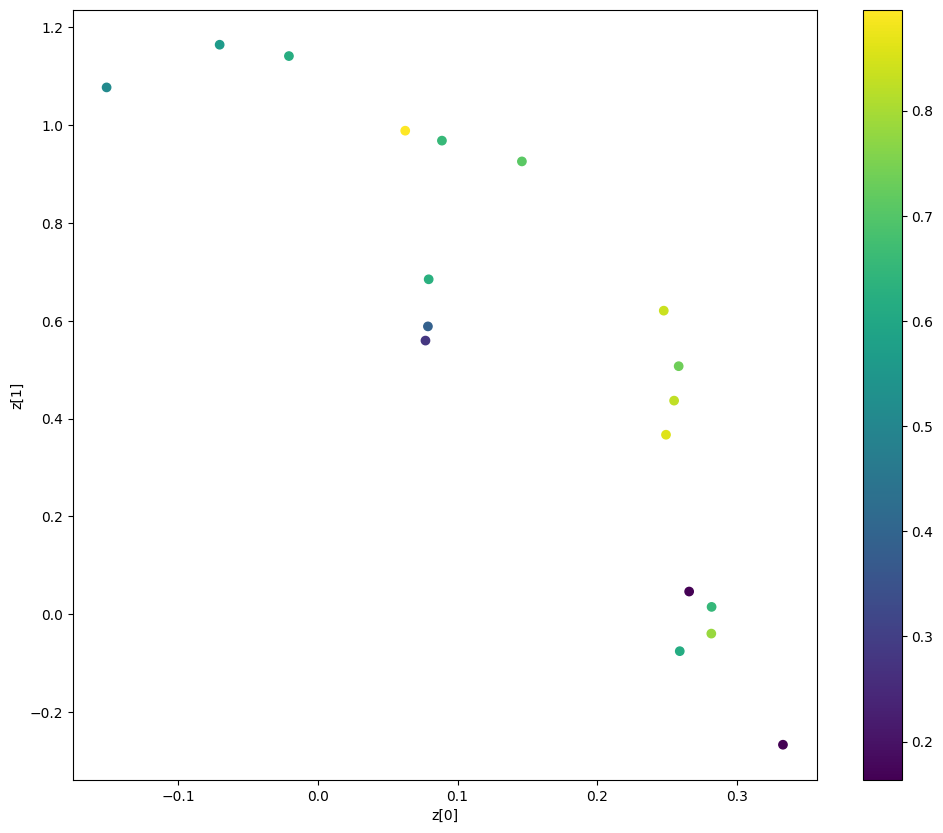

In [65]:
# The line of code is necessary the latent space plot in Colab or Jupyter
%matplotlib inline

# def plot_latent(vae, data, labels): This defines the plot_latent function which takes three arguments:
    # vae: The trained VAE model.
    # data: The input data used to generate the latent space representation (adjacency and
    # feature tensors).
    # labels: The property values (QED scores) of the molecules
def plot_latent(vae, data, labels):

    # display a 2D plot of the property in the latent space
    # z_mean, _ = vae.encoder.predict(data): This line uses the encoder part of the VAE
     # (vae.encoder) to predict the latent space representation (z_mean) of the input data.
     # The underscore _ is used to ignore the second output of the encoder (which is usually
     # the variance).
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10)) # Creates a plot figure with a specified size 12 in by 10 in.

    # plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels): This creates the scatter plot:
        # z_mean[:, 0]: Represents the values of the first dimension of the latent space.
        # z_mean[:, 1]: Represents the values of the second dimension of the latent space.
        # c=labels: This assigns colors to the points based on the labels (QED scores).
        # Molecules with similar QED scores will have similar colors.
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar() # This adds a colorbar to the plot to show the mapping between colors and QED scores.

    # plt.xlabel("z[0]"), plt.ylabel("z[1]"): These lines label the x and y axes of the plot.
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show() # Displays the created plot

# plot_latent(model, [adjacency_tensor[:], feature_tensor[:]], qed_tensor[:]): This line calls
# the plot_latent function with:
    # model: The trained VAE model.
    # [adjacency_tensor[:], feature_tensor[:]]: The adjacency and feature tensors of the molecules,
    # used as input to the encoder.
    # qed_tensor[:]: The QED scores of the molecules, used to color the points in the scatter plot.
plot_latent(model, [adjacency_tensor[:], feature_tensor[:]], qed_tensor[:])

#Suplemental Code

In [ ]:
'''
QED (Quantitative Estimate of Drug-likeness): This score tells us how likely a molecule is to
be a good drug candidate. Higher QED scores generally indicate better drug-likeness.
SAS (Synthetic Accessibility Score): This score estimates how easy or difficult it is to
synthesize a molecule in a laboratory. Lower SAS scores suggest that the molecule is easier to
synthesize.
LogP (Octanol-Water Partition Coefficient): This value represents the solubility of a molecule
in oil (octanol) compared to water. It is an important indicator of how a drug might be
absorbed and distributed in the body.
'''

# Function to calculate QED (Quantitative Estimate of Drug-likeness)
def calculate_qed(mol):
    try:
        return QED.qed(mol)
    except:
        return None

# Function to calculate synthetic accessibility score (SAS)
def calculate_sas(mol):
  try:
    return sascorer.calculateScore(mol)
  except:
    return None

# Function to calculate LogP
def calculate_logp(mol):
    try:
        return Crippen.MolLogP(mol)
    except:
        return None

# Read the CSV file containing SMILES data
def process_smiles_data(input_file, output_file):
    # Load CSV with SMILES data
    df = pd.read_csv(input_file)

    # Create columns for QED, SAS, and logP
    df['qed'] = None
    df['sas'] = None
    df['logP'] = None

    # Loop through each SMILES and calculate descriptors
    for index, row in df.iterrows():
        smiles = row['smiles'] # File w/ SMILES has column header titled smiles
        mol = Chem.MolFromSmiles(smiles)

        if mol:
            # Calculate descriptors
            df.at[index, 'qed'] = calculate_qed(mol)
            df.at[index, 'sas'] = calculate_sas(mol)
            df.at[index, 'logP'] = calculate_logp(mol)

    # Save the modified dataframe to a new CSV
    df.to_csv(output_file, index=False)

# File path to file with SMILES;
csv_path = '/content/drive/My Drive/VAE_GAN_Colab_Notebooks/Data/best_scores_VAE_just SMILES no descriptors.csv' # Change this to your file with smiles
# Provide your input and output file names
input_file = csv_path  # Your input CSV file
output_file = 'smiles_with_descriptors.csv'  # Output CSV file with descriptors

# Process the SMILES data and save to the new CSV file
process_smiles_data(input_file, output_file)

print(f"Descriptors added and saved to {output_file}")